# Splityield model reduction

## Data inspection

In [2]:
# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [3]:
# Import splityield data
df = pd.read_csv('splityield.txt', sep="\\t", engine="python")

# Display the first few rows
df.head()

,yield,block,irrigation,density,fertilizer
0,90,A,control,low,N
1,95,A,control,low,P
2,107,A,control,low,NP
3,92,A,control,medium,N
4,89,A,control,medium,P


In [4]:
# Check missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   yield       72 non-null     int64 
 1   block       72 non-null     object
 2   irrigation  72 non-null     object
 3   density     72 non-null     object
 4   fertilizer  72 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.9+ KB


There are no missing values and the data types seem correct: we have continuous variable yield and the categorical variables block, irrigation, density and fertilizer. We just need to rename the "yield" column to avoid conflicts with the yield operator in Python.

In [5]:
# Rename the yield column
df.rename(columns={"yield": "crop_yield"}, inplace=True)

## Plot the data with boxplots

We can visually check for differences in yield based on the different factors by looking at boxplots.

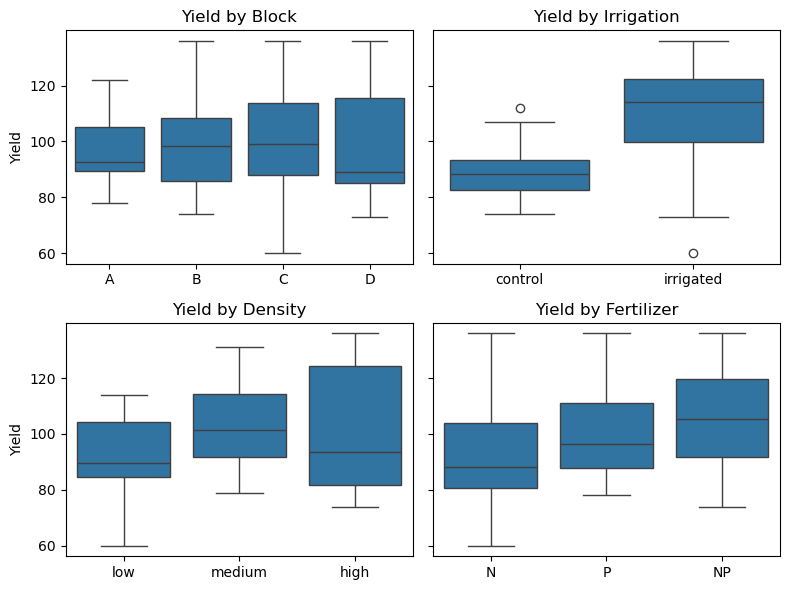

In [6]:
# Identify categorical variables in the dataset
categorical_vars = df.select_dtypes(include=["object"]).columns

# Create a 2x2 grid of boxplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharey=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot boxplots for each categorical variable
for i, cat_var in enumerate(categorical_vars):
    sns.boxplot(x=cat_var, y="crop_yield", data=df, ax=axes[i])
    axes[i].set_title(f"Yield by {cat_var.capitalize()}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel("Yield")

plt.tight_layout()
plt.show()

Block seems to have little effect on yield which is good because we are not interested in differences between different experimental blocks. Irrigation seems to make a difference. Density and fertilizer seem to make a difference, but not all of the levels (e.g. medium and high density) are different.

In order to see the interactions, we can do grouped boxplots. We will leave out the block because it does not seem to have an effect and the figure would get too crowded.

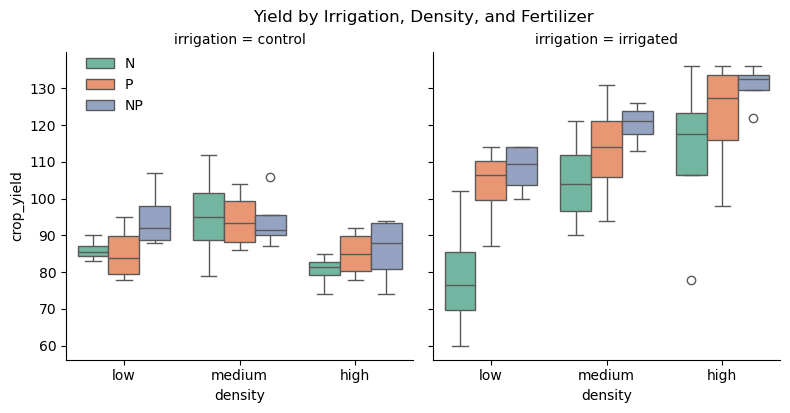

In [7]:
# Use FacetGrid to add subplots for the fourth variable
g = sns.FacetGrid(df, col="irrigation", height=4, aspect=1)
g.map_dataframe(sns.boxplot, x="density", y="crop_yield", hue="fertilizer", order=None, palette="Set2")
g.add_legend()
g.legend.set_bbox_to_anchor((0.18, 0.82))  # Position in the upper left of the first plot

# Set title for the entire plot
g.figure.suptitle("Yield by Irrigation, Density, and Fertilizer", y=1.02)
plt.show()

We can see some potential interaction: for example at the difference between high density crops that are not irrigated versus the high density crops that are irrigated. For the irrigated crops, the higher density leads to higher yield, but for non-irrigated crops, increasing the density does not seem to increase yield.

## Check assumptions

- independent samples
- equal sample sizes of groups
- equal variances of groups
- normal distribution of the dependent variable (within each group)
- normal distribution of errors/residuals

In [8]:
for cat_var in categorical_vars:
    print(df[cat_var].value_counts(),'\n')

block
A    18
B    18
C    18
D    18
Name: count, dtype: int64 

irrigation
control      36
irrigated    36
Name: count, dtype: int64 

density
low       24
medium    24
high      24
Name: count, dtype: int64 

fertilizer
N     24
P     24
NP    24
Name: count, dtype: int64 



In [9]:
# Use pd.crosstab() to calculate the number of values for all combinations
table = pd.crosstab(index=[df['block'], df['irrigation'], df['density'], df['fertilizer']], columns='count')
table.columns.name = 'group'
table

group                                count
block irrigation density fertilizer       
A     control    high    N               1
                         NP              1
                         P               1
                 low     N               1
                         NP              1
...                                    ...
D     irrigated  low     NP              1
                         P               1
                 medium  N               1
                         NP              1
                         P               1

[72 rows x 1 columns]

In [10]:
# Extract the unique values from the 'count' column
unique_counts = table['count'].unique()

# Print the unique counts
print("Unique counts in the table:")
print(unique_counts)

Unique counts in the table:
[1]


In [11]:
# calculate standard deviation
std_group = df.groupby('irrigation')['crop_yield'].std()
print(std_group)

irrigation
control       9.026944
irrigated    18.993900
Name: crop_yield, dtype: float64


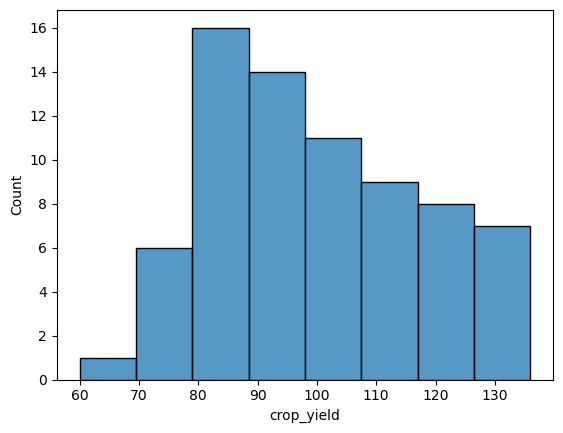

In [21]:
# histogram
sns.histplot(x='crop_yield', data=df, binwidth=10)
plt.show()

## Build ANOVA and do model reduction

In [13]:
formula_1 = 'crop_yield ~ C(irrigation) * C(density) * C(fertilizer)'
model_1 = ols(formula_1, df).fit()
aov_table_1 = anova_lm(model_1, typ=2)
aov_table_1.round(3)

,sum_sq,df,F,PR(>F)
C(irrigation),8277.556,1.0,59.575,0.000
C(density),1758.361,2.0,6.328,0.003
C(fertilizer),1977.444,2.0,7.116,0.002
C(irrigation):C(density),2747.028,2.0,9.885,0.000
C(irrigation):C(fertilizer),953.444,2.0,3.431,0.040
C(density):C(fertilizer),304.889,4.0,0.549,0.701
C(irrigation):C(density):C(fertilizer),234.722,4.0,0.422,0.792
Residual,7503.000,54.0,NaN,NaN


In [14]:
formula_2 = 'crop_yield ~ (C(irrigation) + C(density) + C(fertilizer))**2'
model_2 = ols(formula_2, df).fit()
aov_table_2 = anova_lm(model_2, typ=2)
aov_table_2.round(3)

,sum_sq,df,F,PR(>F)
C(irrigation),8277.556,1.0,62.046,0.000
C(density),1758.361,2.0,6.590,0.003
C(fertilizer),1977.444,2.0,7.411,0.001
C(irrigation):C(density),2747.028,2.0,10.296,0.000
C(irrigation):C(fertilizer),953.444,2.0,3.573,0.034
C(density):C(fertilizer),304.889,4.0,0.571,0.684
Residual,7737.722,58.0,NaN,NaN


In [15]:
formula_3 = 'crop_yield ~ C(irrigation) * C(density) + C(irrigation) * C(fertilizer)'
model_3 = ols(formula_3, df).fit()
aov_table_3 = anova_lm(model_3, typ=2)
aov_table_3.round(3)

,sum_sq,df,F,PR(>F)
C(irrigation),8277.556,1.0,63.811,0.000
C(density),1758.361,2.0,6.778,0.002
C(fertilizer),1977.444,2.0,7.622,0.001
C(irrigation):C(density),2747.028,2.0,10.588,0.000
C(irrigation):C(fertilizer),953.444,2.0,3.675,0.031
Residual,8042.611,62.0,NaN,NaN


Model 3 is the most parsimonious model!

In [16]:
# Extract the sum of squares values for the model and residuals
SS_model = aov_table_3['sum_sq'].iloc[:-1].sum()  # sum of squares for the model factors (excluding residual)
SS_residual = aov_table_3['sum_sq'].iloc[-1]  # sum of squares for the residual

# Total sum of squares (SST)
SS_total = SS_model + SS_residual

# Explained variance
explained_variance = SS_model / SS_total

# Output the explained variance
print(f"Explained Variance: {explained_variance:.3f}")

Explained Variance: 0.661


## Check residuals

<Axes: ylabel='Count'>

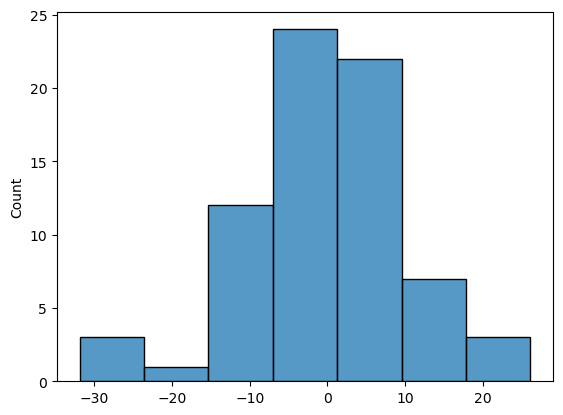

In [17]:
sns.histplot(model_3.resid, binwidth=8)

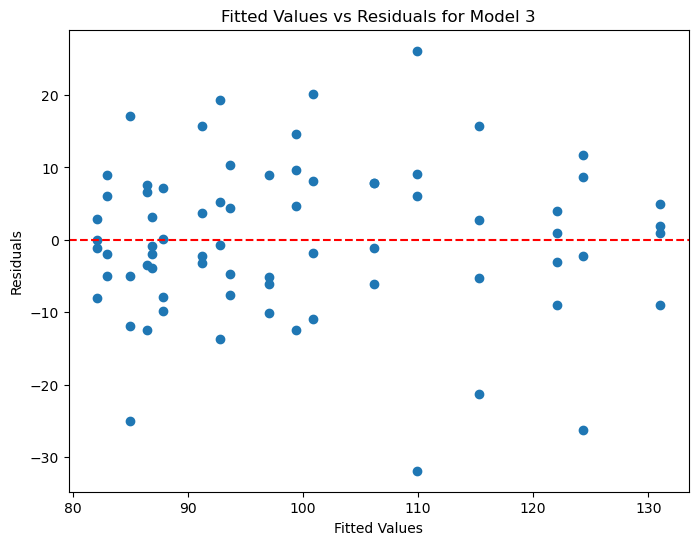

In [18]:
# Obtain fitted values (predicted values) from the model
fitted_values = model_3.fittedvalues

# Obtain residuals from the model
residuals = model_3.resid

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='red', linestyle='--')

# Set labels and title
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs Residuals for Model 3')

# Show plot
plt.show()

## Linear Mixed Effect Model - Reduction based on p-values 
<mark>How to proceed if some of the p-values of a variable are significant and some are not? </mark>

In [24]:
# Create a nested grouping variable for block/irrigation/density
df['nested_group'] = df['block'].astype(str) + "/" + df['irrigation'].astype(str) + "/" + df['density'].astype(str)

md = smf.mixedlm('crop_yield ~ 1', df, groups=df["nested_group"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: crop_yield
No. Observations: 72      Method:             REML      
No. Groups:       24      Scale:              137.0695  
Min. group size:  3       Log-Likelihood:     -297.0568 
Max. group size:  3       Converged:          Yes       
Mean group size:  3.0                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025  0.975]
--------------------------------------------------------
Intercept    99.722    3.221 30.963 0.000 93.410 106.035
Group Var   203.253    7.626                            



In [25]:
md = smf.mixedlm('crop_yield ~ irrigation * density * fertilizer', df, groups=df["nested_group"])
mdf = md.fit()
print(mdf.summary())

                                 Mixed Linear Model Regression Results
Model:                            MixedLM                 Dependent Variable:                 crop_yield
No. Observations:                 72                      Method:                             REML      
No. Groups:                       24                      Scale:                              86.3554   
Min. group size:                  3                       Log-Likelihood:                     -218.8310 
Max. group size:                  3                       Converged:                          Yes       
Mean group size:                  3.0                                                                   
--------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------------------------

In [27]:
md = smf.mixedlm('crop_yield ~ (irrigation + density + fertilizer)**2', df, groups=df["nested_group"])
mdf = md.fit()
print(mdf.summary())

                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           crop_yield
No. Observations:            72                Method:                       REML      
No. Groups:                  24                Scale:                        83.5883   
Min. group size:             3                 Log-Likelihood:               -233.5832 
Max. group size:             3                 Converged:                    Yes       
Mean group size:             3.0                                                       
---------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                  82.472    5.443 15.151 0.000  71.803  93.141
irrigation[T.irrigated]                    27.806    7.06

In [28]:
md = smf.mixedlm('crop_yield ~ irrigation * density + irrigation * fertilizer', df, groups=df["nested_group"])
mdf = md.fit()
print(mdf.summary())

                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           crop_yield
No. Observations:            72                Method:                       REML      
No. Groups:                  24                Scale:                        82.9187   
Min. group size:             3                 Log-Likelihood:               -245.9721 
Max. group size:             3                 Converged:                    Yes       
Mean group size:             3.0                                                       
---------------------------------------------------------------------------------------
                                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                  82.083    4.995 16.433 0.000  72.293  91.873
irrigation[T.irrigated]                    27.806    7.06

Same outcome with linear mixed effect model as with ANOVA!